# Demand Forecasting: NYC - Yellow Taxi Analysis

In [1]:
# Install necessary packages (uncomment if needed)
# !pip install pandas numpy matplotlib seaborn scikit-learn statsmodels prophet folium

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

from pmdarima.arima import auto_arima
import gdown
import pyarrow
from math import sqrt


# Set visualization style
sns.set_style("whitegrid")

# Problem Statement
### The goal of this project is to be able to predict forecast trip demand for January 2024. Ideally, January data from a previous year would help produce better results but since we only have 1 month of data. We will use this data to split between train and test. From a business perspective I would assume some questions of interest are:

### What NYC zones have the highest traffic?
### Are there significant differences in traffic week to week?
### What is the average trip distance?

# Data Preparation
### Let's begin the data load directly from google file locations using a sweet gdown package API

In [2]:
# Snagged the gdown code from Chat-GPT because I was unfamiliar with google drive APIs. I simply tweaked the file id locations and the file names to download the necessary files for this project.

# Google Drive file ID (Extracted from the shared link)
file_id = "17e9mOxiqIMpQE4dJgsEyLtC_NYVLkQuK"
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
output = "yellow_tripdata_2024-01.parquet"
gdown.download(url, output, quiet=False)

# Load Parquet file
df = pd.read_parquet(output)

# Taxi Zone Lookup File
file_id = "1ULehMkwfcYfWQRn8P0--KVwrm46XW8Wx"
url = f"https://drive.google.com/uc?id={file_id}"

# Download CSV file
zonecsv = "taxi_zone_lookup.csv"
gdown.download(url, zonecsv, quiet=False)

# Load CSV
df_zones = pd.read_csv(zonecsv)
print(df_zones.head())

Downloading...
From: https://drive.google.com/uc?id=17e9mOxiqIMpQE4dJgsEyLtC_NYVLkQuK
To: c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\yellow_tripdata_2024-01.parquet
100%|██████████| 50.0M/50.0M [00:02<00:00, 16.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ULehMkwfcYfWQRn8P0--KVwrm46XW8Wx
To: c:\Users\jonal\OneDrive\Documents\FranklinU\DATA695\Final Project Repo\FranklinU\taxi_zone_lookup.csv
100%|██████████| 12.3k/12.3k [00:00<00:00, 2.14MB/s]

   LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone


### Now that the data has been loaded successfully, lets dive into some of the data. It appears that there are some null values but it only makes up about 4.7% of the data. I suspect we can drop these without a major impact to any column or features. Let's be safe and dig a little deeper

In [3]:
# What percent of records are null or missing?
df.isnull().sum()/len(df)

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          0.047278
trip_distance            0.000000
RatecodeID               0.047278
store_and_fwd_flag       0.047278
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     0.047278
Airport_fee              0.047278
dtype: float64

In [4]:
# Lets find out a little more about these records
nulldf = df[df['passenger_count'].isnull()]
nulldf

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
2824462,2,2024-01-01 00:34:19,2024-01-01 00:51:22,NaN,2.04,NaN,None,143,141,0,12.72,0.00,0.5,0.00,0.00,1.0,16.72,NaN,NaN
2824463,1,2024-01-01 00:14:31,2024-01-01 00:19:29,NaN,1.60,NaN,None,236,238,0,9.30,1.00,0.5,2.86,0.00,1.0,17.16,NaN,NaN
2824464,1,2024-01-01 00:35:11,2024-01-01 01:13:40,NaN,0.00,NaN,None,142,79,0,21.01,0.00,0.5,0.00,0.00,1.0,25.01,NaN,NaN
2824465,1,2024-01-01 00:33:37,2024-01-01 00:50:34,NaN,0.00,NaN,None,237,4,0,17.79,0.00,0.5,0.00,0.00,1.0,21.79,NaN,NaN
2824466,1,2024-01-01 00:49:04,2024-01-01 01:01:16,NaN,0.00,NaN,None,244,50,0,34.65,0.00,0.5,0.00,0.00,1.0,38.65,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


In [5]:
# Lets check where these nulls lie through the month of Jan 2024
nulldf['datestr'] = nulldf['tpep_pickup_datetime'].astype('str').str[:10]
nulldf.groupby('datestr').size()

C:\Users\jonal\AppData\Local\Temp\ipykernel_30372\4094450269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nulldf['datestr'] = nulldf['tpep_pickup_datetime'].astype('str').str[:10]


datestr
2024-01-01    10518
2024-01-02     2158
2024-01-03     1961
2024-01-04     2602
2024-01-05     3083
2024-01-06     5191
2024-01-07     2585
2024-01-08     2102
2024-01-09     7375
2024-01-10     2982
2024-01-11     3322
2024-01-12     4393
2024-01-13     4653
2024-01-14     5424
2024-01-15     2865
2024-01-16     5442
2024-01-17     8035
2024-01-18     5873
2024-01-19     4073
2024-01-20     8438
2024-01-21     5289
2024-01-22     2955
2024-01-23     4210
2024-01-24     3630
2024-01-25     5211
2024-01-26     4508
2024-01-27     4557
2024-01-28     7431
2024-01-29     2573
2024-01-30     3214
2024-01-31     3509
dtype: int64

In [6]:
nulldf.groupby('PULocationID').size()

PULocationID
1         3
2         1
3        17
4       956
6         4
       ... 
261     733
262    4278
263    3261
264     165
265     283
Length: 246, dtype: int64

### It looks like these nulls are scattered across all days in Jan 2024 along with diverse locations. Lets go ahead and drop these nulls and begin joining the zone data with the taxi trips data. Additionally there is noise in the data related to previous months. About 10 records are from the calendar year of 2023, 5 records from past years and some extra dates in the month of Feb 2024. This is not enough data to provide some useful insights. We can remove this inconsistent data

In [7]:
noise_df = df[df['tpep_pickup_datetime'] < "2023-12-31 23:59:59"]
noise_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
256,2,2023-12-31 23:56:46,2024-01-01 00:12:06,2.0,2.38,1.0,N,236,142,1,15.6,1.00,0.5,1.00,0.00,1.0,21.60,2.5,0.00
369,2,2023-12-31 23:39:17,2023-12-31 23:42:00,2.0,0.47,1.0,N,90,68,1,5.1,1.00,0.5,0.00,0.00,1.0,10.10,2.5,0.00
753,2,2023-12-31 23:41:02,2023-12-31 23:48:03,1.0,0.40,1.0,N,246,246,2,7.2,1.00,0.5,0.00,0.00,1.0,12.20,2.5,0.00
2210,2,2023-12-31 23:57:17,2024-01-01 00:01:50,1.0,0.53,1.0,N,144,211,1,5.8,1.00,0.5,2.16,0.00,1.0,12.96,2.5,0.00
2615,2,2023-12-31 23:56:45,2024-01-01 00:00:28,1.0,0.97,1.0,N,163,237,1,6.5,1.00,0.5,2.00,0.00,1.0,13.50,2.5,0.00
2985,2,2023-12-31 23:49:12,2024-01-01 00:04:32,1.0,3.14,1.0,N,234,237,1,17.0,1.00,0.5,6.60,0.00,1.0,28.60,2.5,0.00
3176,2,2023-12-31 23:47:28,2023-12-31 23:57:07,2.0,1.44,1.0,N,68,137,1,10.7,1.00,0.5,3.14,0.00,1.0,18.84,2.5,0.00
4137,2,2023-12-31 23:58:35,2024-01-01 00:13:06,6.0,8.39,1.0,N,138,217,2,33.1,6.00,0.5,0.00,0.00,1.0,42.35,0.0,1.75
4142,2,2023-12-31 23:58:37,2024-01-01 00:08:37,2.0,0.59,1.0,N,161,170,1,10.0,1.00,0.5,3.75,0.00,1.0,18.75,2.5,0.00
8628,2,2023-12-31 23:54:27,2024-01-01 00:13:12,1.0,7.70,1.0,N,229,244,1,33.1,1.00,0.5,7.62,0.00,1.0,45.72,2.5,0.00


In [8]:
# Handle missing values (if any)
df.dropna(inplace=True)
df = df[df['tpep_pickup_datetime'] > "2023-12-31 23:59:59"]
df = df[df['tpep_pickup_datetime'] < "2024-02-01 00:00:01"]

# Convert datetime column
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])

# Extract time features
df["hour"] = df["tpep_pickup_datetime"].dt.hour
df["day"] = df["tpep_pickup_datetime"].dt.day
df["weekday"] = df["tpep_pickup_datetime"].dt.weekday

# Merge with taxi zone data (if location-based analysis is needed)
df = df.merge(df_zones, left_on="PULocationID", right_on="LocationID", how="left")

In [9]:
# View sample of data to ensure join is good
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,congestion_surcharge,Airport_fee,hour,day,weekday,LocationID,Borough,Zone,service_zone
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,...,22.70,2.5,0.0,0,1,0,186,Manhattan,Penn Station/Madison Sq West,Yellow Zone
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,...,18.75,2.5,0.0,0,1,0,140,Manhattan,Lenox Hill East,Yellow Zone
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,...,31.30,2.5,0.0,0,1,0,236,Manhattan,Upper East Side North,Yellow Zone
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,...,17.00,2.5,0.0,0,1,0,79,Manhattan,East Village,Yellow Zone
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,...,16.10,2.5,0.0,0,1,0,211,Manhattan,SoHo,Yellow Zone


# Exploratory Data Analysis
### Next up is some geo analysis of the taxi data. We can see that there are some strong trends by pick up location. The zones with the highest pickup traffic are JFK Airport, Upper East Side and Midtown. This also indicates that location is a very important feature to understand monthly if not weekly/daily NYC traffic. I would assume a high priority forecast are for the high traffic areas. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


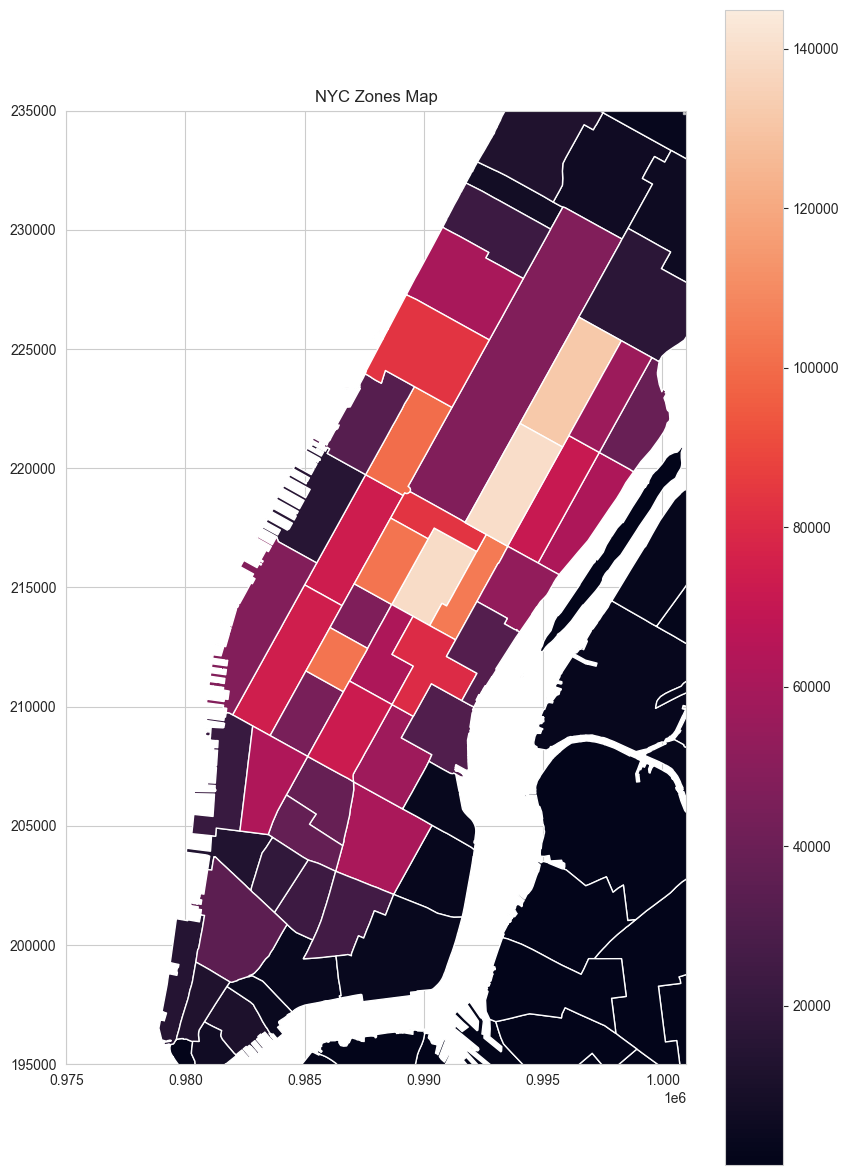

In [10]:
import geopandas

# Load taxi zone shapefile to view geo map of taxi zones
gdf = geopandas.read_file('C:/Users/jonal/Downloads/taxi_zones/taxi_zones.shp')

# Aggregate data to get trip counts
zone_cnts = df.groupby(["LocationID"]).size().reset_index(name="trip_count")

# Merge with taxi zone data (if location-based analysis is needed)
gdf = gdf.merge(zone_cnts, left_on="LocationID", right_on="LocationID", how="left")
gdf.dropna(inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 15))
gdf.plot(column="trip_count", 
         ax=ax, 
         legend=True,
         missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    })
plt.legend(prop={'size':2})
ax.set_title("NYC Zones Map")

ax.set_xlim(975000, 1001000)
ax.set_ylim(195000,235000)
plt.show()

In [11]:
# Merge with taxi zone data 
zone_cnts = zone_cnts.merge(df_zones, left_on="LocationID", right_on="LocationID", how="left")
zone_cnts.sort_values(by='trip_count', ascending=False)

,LocationID,trip_count,Borough,Zone,service_zone
124,132,144866,Queens,JFK Airport,Airports
227,237,139236,Manhattan,Upper East Side South,Yellow Zone
153,161,139031,Manhattan,Midtown Center,Yellow Zone
226,236,131358,Manhattan,Upper East Side North,Yellow Zone
154,162,104329,Manhattan,Midtown East,Yellow Zone
...,...,...,...,...,...
168,176,1,Staten Island,Oakwood,Boro Zone
104,111,1,Brooklyn,Green-Wood Cemetery,Boro Zone
100,105,1,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone
28,30,1,Queens,Broad Channel,Boro Zone


### Next up is demand across time granularities

In [12]:
# Aggregate data by days to get trip counts
demand_data = df.groupby(["day"]).size().reset_index(name="trip_count")

# Aggregate data by hour to see trends
hr_cnts = df.groupby(["hour"]).size().reset_index(name="hr_count")

# Aggregate average trip distance by day for trends
day_distance = df.groupby(["weekday"])['trip_distance'].mean().reset_index(name="avg_distance_mi")

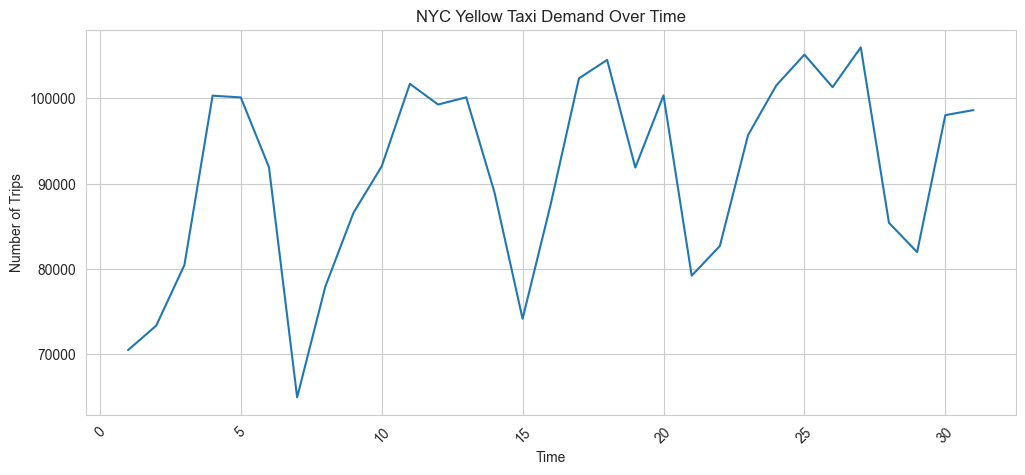

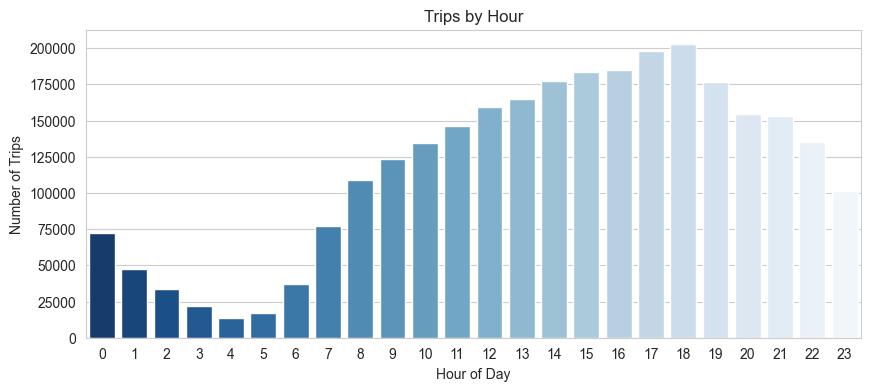

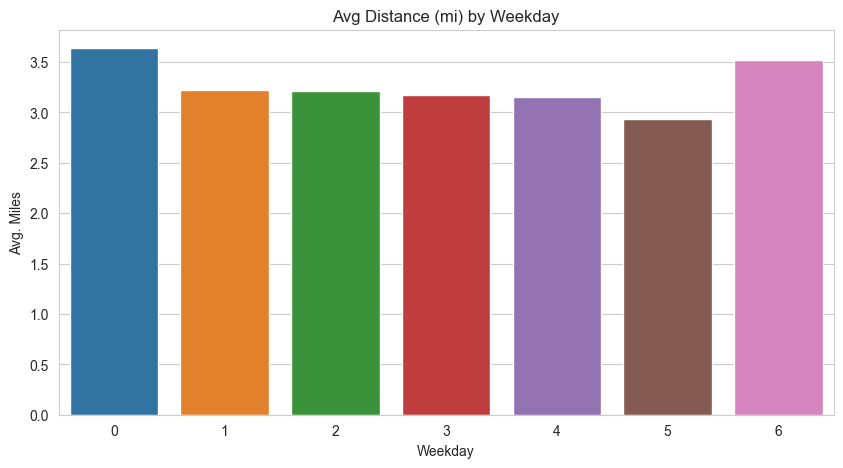

In [13]:
# Plot daily trip demand
plt.figure(figsize=(12, 5))
sns.lineplot(data=demand_data, x="day", y="trip_count")
plt.xticks(rotation=45)
plt.title("NYC Yellow Taxi Demand Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.show()

# Check demand distribution by hour
plt.figure(figsize=(10, 4))
sns.barplot(x=hr_cnts['hour'], y=hr_cnts["hr_count"], palette="Blues_r")
plt.title("Trips by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()

# Check average distance by zone
plt.figure(figsize=(10, 5))
sns.barplot(x=day_distance['weekday'], y=day_distance["avg_distance_mi"])
plt.title("Avg Distance (mi) by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Avg. Miles")
plt.show()

### From the different time granularities we can understand trip demand is fairly similary week to week. The slowest days are on Sundays with higher traffic occuring on the Fridays/Saturdays. When looking at average distance by weekday , most taxi distances are similar across weekdays with a slight uptick on Sunday & Monday. These may be high airport travel days. Additionally, most of the trip demand is from 8AM - 11PM roughly. 

# Modeling & Forecasting

### As we approach modeling and forecasting. There are multiple modeling options to use for this prediction. Let's choose between a traditional statistical SARIMAX model and a machine learning model Random Forest Regressor.

### Given the time constraint lets focus on features that we can easily use for future dates (e.g. days, hours, weekdays). The reason behind this is if you need to predict for a future date (e.g. 12-2025) we will also need to predict a feature like fare, avg distance, etc. From a business stand point there are tradeoffs for this. The "predicted" feature also has its residuals and room for error thus potentially leading to less accurate results. This is a whole project in itself.  If we used all these features we could spend quite a bit of time understanding correlation of features or using feature dimension reduction methods to ensure higher accuracy for the model. 

### Although we may not use these features a standard practice is to convert some categorical features into numerical. We can easily do this with label encoding our zones and Store & Fwd Flag features. Standard Machine Learning models need numerical inputs for internal algorithms. Let's go through that excercise anyways.

In [14]:
# Initialize the LabelEncoder
encoder = LabelEncoder()

# Encode the 'store_and_fwd_flag' column
df['store_and_fwd_flag_enc'] = encoder.fit_transform(df['store_and_fwd_flag'])

# Encode the 'Borough' column
df['Borough_enc'] = encoder.fit_transform(df['Borough'])

# Encode the 'Zone' column
df['Zone_enc'] = encoder.fit_transform(df['Zone'])

# Encode the 'service_zone' column
df['service_zone_enc'] = encoder.fit_transform(df['service_zone'])

# Display the first few rows to verify the encoding
df[['store_and_fwd_flag', 'store_and_fwd_flag_enc', 'Borough', 'Borough_enc', 'Zone', 'Zone_enc', 'service_zone', 'service_zone_enc']].head()

,store_and_fwd_flag,store_and_fwd_flag_enc,Borough,Borough_enc,Zone,Zone_enc,service_zone,service_zone_enc
0,N,0,Manhattan,3,Penn Station/Madison Sq West,178,Yellow Zone,3
1,N,0,Manhattan,3,Lenox Hill East,130,Yellow Zone,3
2,N,0,Manhattan,3,Upper East Side North,226,Yellow Zone,3
3,N,0,Manhattan,3,East Village,74,Yellow Zone,3
4,N,0,Manhattan,3,SoHo,202,Yellow Zone,3


### Another best practice is to split your data into train and test split. After trying 80/20, 70/30 & 90/10 splits I have decided to go with a 70/30 split. Althought accuracy would improve with 80/20 and 90/10 , a 70/30 will help in preventing overfitting the training data set. Additionally this is temporal data so the sequence matters, so we're roughly taking the first 3 weeks of data to predict the last week of January. 

### SARIMAX
### We could definitely approach this problem by hour but I know the arima model will struggle to compute this and it tends to struggle with data under daily frequency due to complex patterns. Additionally, I will be using an auto parameter optimizer for the sarimax model. This auto arima optimizer minimizes the error criterion AIC for higher accuracy. 

In [15]:
# Aggregate to a daily level 

df['normalized_dt'] = df['tpep_pickup_datetime'].dt.normalize()
ts_data = df.groupby([ "day", "weekday"]).agg({'normalized_dt' : ['size','max']}).reset_index()
ts_data.columns = [ 'day', 'weekday','y','ds'] 
ts_data.set_index('ds',inplace=True)
ts_data.sort_index(ascending=True)

train = ts_data[ts_data.index <= pd.to_datetime('2024-01-22')]
test = ts_data[ts_data.index > pd.to_datetime('2024-01-22')]

In [16]:
# Define exogenous variables
exog_train = train[['day','weekday']]
exog_test = test[['day','weekday']]

# train model (exogenous variables are assigned to the X parameter). Auto arima calculates best parameters
model = auto_arima(train['y'].sort_index(ascending=True), x=exog_train.sort_index(ascending=True),
                        D=1, m=7, seasonal=True, error_action='warn', trace=True,
                        supress_warnings=True, stepwise=True, random_state=20, n_fits=50)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=319.598, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=317.736, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=320.705, Time=0.04 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=320.229, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=319.526, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=318.865, Time=0.01 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=318.613, Time=0.02 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=318.350, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=319.611, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=320.030, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=321.624, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,1,0)[7] intercept
Total fit time: 0.643 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                   22
Model:             SARIMAX(0, 1, 0, 7)   Log Likelihood                -156.868
Date:                 Mon, 17 Mar 2025   AIC                            317.736
Time:                         20:37:25   BIC                            319.152
Sample:                     01-01-2024   HQIC                           317.721
                          - 01-22-2024                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4463.0667   2263.030      1.972      0.049      27.609    8898.525
sigma2      7.097e+07   2.72e+07      2.607      0.009    1.76e+07    1.24e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.86   Prob(JB):                         0.83
Heteroskedasticity (H):               2.19   Skew:                             0.39
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
num_periods = test['y'].count().tolist()

# Merge predictions with actual to calculate MAPEs
prediction = pd.DataFrame(model.predict(x=exog_test.sort_index(ascending=True), n_periods=num_periods))
prediction.columns = ['Predicted_Sales']
prediction.index = test.index

In [18]:
mse_arima = mean_squared_error(test.y,prediction['Predicted_Sales'])
r2_arima = r2_score(test.y, prediction['Predicted_Sales'])
mape_arima = mean_absolute_percentage_error(test.y, prediction['Predicted_Sales'])

print(f"Mean Absolute Percent Error: {mape_arima}")
print(f"Mean Squared Error: {mse_arima}")
print(f"R-squared: {r2_arima}")

Mean Absolute Percent Error: 0.045907493173584925
Mean Squared Error: 30412952.807407405
R-squared: 0.5024486089843596


### As our baseline model we can see it performed fairly well. with a 4.5% MAPE

### Random Forest Regressor

### Next up is our machine learning model which is a Random Forest Regressor. The Random Forest Regressor can handle the hourly granularity well so I will include this feature along with day and weekday in the model build

In [19]:
# Aggregate data to get trip counts
rf_data = df.groupby(["hour", "day", "weekday"]).size().reset_index(name="trip_count")
rf_data

,hour,day,weekday,trip_count
0,0,1,0,5576
1,0,2,1,885
2,0,3,2,1171
3,0,4,3,1129
4,0,5,4,1803
...,...,...,...,...
739,23,27,5,6885
740,23,28,6,1730
741,23,29,0,1962
742,23,30,1,2438


### For the random forest regressor I have chosen to use a parameter tuning method called GridSearch Cross Validation. 

In [20]:
# Lets split the data by calendar date. Lets traing the random forest regressor on the first 22 days of the month which is about 70% of the data. We can test on the remaining days
X_train, X_test, y_train, y_test = rf_data[rf_data['day'] <= 22].drop("trip_count", axis=1), rf_data[rf_data['day'] > 22].drop("trip_count", axis=1), rf_data[rf_data['day'] <= 22]["trip_count"], rf_data[rf_data['day'] > 22]["trip_count"]

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42) 

# Define hyperparameter grid for tuning
param_grid = {
    "n_estimators": [50, 100, 200],   # Number of trees
    "max_depth": [None, 10, 20],      # Depth of trees
    "min_samples_split": [2, 5, 10],  # Min samples to split a node
    "min_samples_leaf": [1, 2, 4]     # Min samples in a leaf node
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(rf_regressor, param_grid, cv=6, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train best model
best_rf = grid_search.best_estimator_

# Save model prediction results
y_pred = best_rf.predict(X_test)

Fitting 6 folds for each of 81 candidates, totalling 486 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [21]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percent Error: {mape}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Percent Error: 0.08683985837486154
Mean Squared Error: 185848.14711990743
R-squared: 0.9645641378945384


### As a comparison model this model also perform fairly well. We see a MAPE value of 8.6%

# Discussion

In [22]:
# Lets join all the data together to see the actual vs predicted
rf_ts = X_test.reset_index().merge(pd.DataFrame(data = y_pred), left_index=True, right_index=True)
final_df = pd.merge(test.reset_index(), rf_ts.groupby(['weekday','day']).sum(), left_on=['day','weekday'], right_on=['day','weekday'])
final_df


,ds,day,weekday,y,index,hour,0
0,2024-01-23,23,1,95681,9084,276,88651.020
1,2024-01-24,24,2,101490,9108,276,96164.490
2,2024-01-25,25,3,105107,9132,276,99297.965
3,2024-01-26,26,4,101296,9156,276,95107.820
4,2024-01-27,27,5,105958,9180,276,98795.270
5,2024-01-28,28,6,85406,9204,276,80621.400
6,2024-01-29,29,0,81974,9228,276,82219.775
7,2024-01-30,30,1,98019,9252,276,88651.020
8,2024-01-31,31,2,98611,9276,276,96164.490


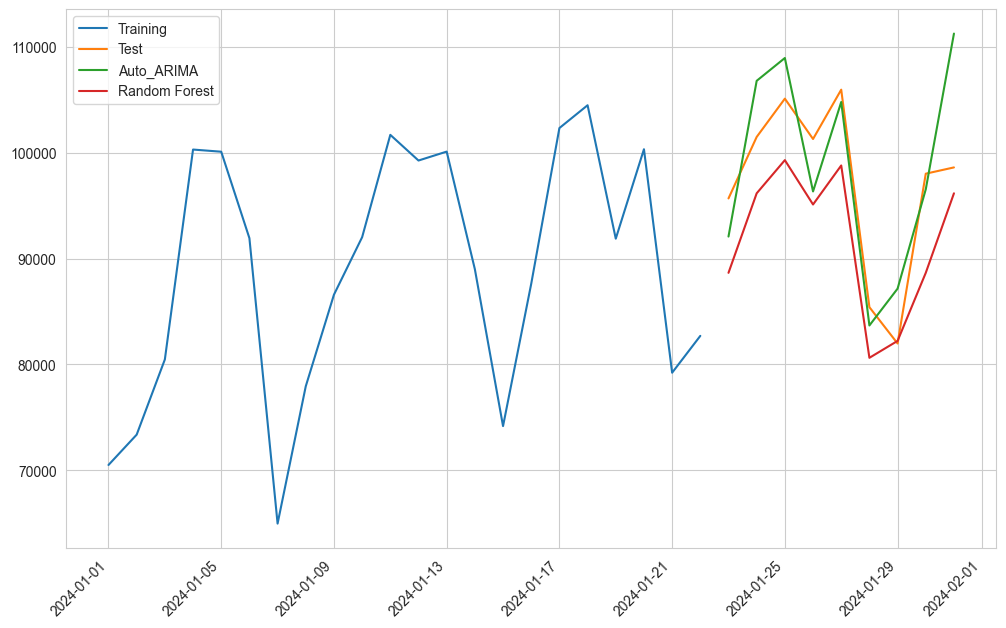

In [23]:
# Final plots of all predictions
plt.figure(figsize=(12,7))
plt.plot(train.groupby(train.index)['y'].sum(),label="Training")
plt.plot(test.groupby(test.index)['y'].sum(),label="Test")
plt.plot(prediction.groupby(prediction.index)['Predicted_Sales'].sum(),label="Auto_ARIMA")
plt.plot(final_df[['ds',0]].groupby('ds').sum(),label="Random Forest")
plt.xticks(rotation=45, ha='right')
plt.legend(loc = 'best')
plt.show()

### The reason I chose SARIMAX was because this is typically a very explainable and "simpler" model. This is perfect for a baseline model. The reason I chose the random forest is because although it's tougher to explain, it can handle complex patterns very well and is still relatively light. We can see that these two models performed relatively similarly so here are some takeways and tradeoffs from both models. 

### Random Forest Regressor:
####     1. This model could handle the granularity of the data down to the hour level. I'd be comfortable using this type of model if focusing on taxi zone predictions or more granular data. 
####     2. This ensemble model is relatively light & fast compared to a model such as a neural network or even the SARIMAX baseline model. Additionally, the random forest scales relatively well with large data sets. 
####     3. The random forest model can be harder to explain at times given its "black-box" nature, however breaking down some of the ensemble trees I should still be able to explain some basic weights from the model. It does very well with anomalies and noisy data. 

### Time Series SARIMAX:
####     1. This model struggled at first with hourly data and will also struggle with additional complex features. 
####     2. Althought this SARIMAX model was relatively fast, it does not scale well with larger data sets. 
####     3. This model is very easy to explain since it is linearly based and carries explainable coefficients. However this model will struggle with anomalies and noisy outliers in the data. 

# Recommendations

### Given the time constraint, I also would have built a Sequential Neural Network model. This type of model is computationally heavy however it typically performs very well being able to handle very complex patterns. I would have also liked to have incorporating additional data for features such as weather, Airport arrival volume, large events (Super Bowl, etc.) or holidays. My final recommendation would be to use a model such as the Random Forest but incorporating these additional features.

### From a spatial standpoint, taxi zones look like they are vital for operational decisions. As a business, I would imagine the priority it is to staff and provide taxis in a high volume zone  (such as Airport, Upper East Side & Midtown zones). Tweaking my forecasts for high volume zones is another way I would have built the predictions. 

# Final Notes

### I really had fun exploring and putting this project together. Learning from mentors and higher education in the past, I typically follow the CRISP DM/ML model as my methodology for data science projects. 
### I also tested out GitHub Co-Pilot via my jupyter notebook. It was super handy with some of the auto-completion texts. Other than that I typically only use Chat-GPT to check my work and some syntax help for the plotly graphs.
### Cheers!